# HRP (Hierarchical Risk Parity)

```
Оптимизация портфеля с помощи HRP (с периодической ребалансировкой)

```

**План работ**

* **Шаг 1: Подготовка данных**
    + Берем данные за более длинный период (например, 3 года).
    + Рассчитываем робастную ковариационную матрицу. (Отличный метод — Ledoit-Wolf Shrinkage. Он "ужимает" историческую матрицу к более стабильной цели, снижая шум и делая ее более устойчивой для будущего)



* **Шаг 2: Расчет весов**
    + Проводим HRP на этой робастной ковариационной матрице. Получаем целевые веса портфеля.
    + Применяем любые бизнес-ограничения (например, максимальный вес на один актив не более 15%).


* **Шаг 3: Анализ рисков**
    + Теперь, когда у вас есть фиксированные веса портфеля, используйте Монте-Карло для ответа на вопросы:
        - Каков диапазон ожидаемой доходности? (Хотя HRP ее не использует, ее можно оценить для симуляции).
        - Каков ожидаемый VaR (Value-at-Risk) или CVaR (Conditional VaR)? То есть, какой убыток мы можем понести в 5% худших случаев?
        - Какова ожидаемая максимальная просадка?
    + Стресс-тестирование: Не просто симулируйте прошлое, а симулируйте "плохие" сценарии:
        - "А что, если корреляции между всеми активами резко вырастут до 0.8 (сценарий паники)?"
        - "А что, если волатильность технологического сектора удвоится?"
        - Моделирование несколько таких шоковых сценариев для того что бы посмотреть, как поведет себя HRP-портфель.


* **Шаг 4: Принятие решения и ребалансировка**
    * Результаты ***Шага 3*** отвечают на вопрос "соответствует ли риск-профиль портфеля толерантности к риску?".
    * Если VaR и потенциальные просадки приемлемы — проводим ребалансировку к целевым весам HRP.
    * Если риск-профиль оказывается слишком высоким, это сигнал о том, что текущая рыночная среда очень рискованная. 
    Правильное решение в этом случае — снизить общий риск портфеля. 
    Например, пропорционально уменьшить долю всех рисковых активов и увеличить долю кэша или безрисковых активов.

## 0. Data load

In [1]:
import requests

import apimoex
import pandas as pd


In [2]:
with requests.Session() as session:
    # securities = apimoex.get_board_securities(session)
    securities = apimoex.get_index_tickers(session, index="IMOEX")

securities

[{'ticker': 'AFKS',
  'from': '2012-09-18',
  'till': '2025-08-18',
  'tradingsession': 3},
 {'ticker': 'AFLT',
  'from': '2001-04-28',
  'till': '2025-08-18',
  'tradingsession': 3},
 {'ticker': 'AGRO',
  'from': '2015-12-16',
  'till': '2024-12-02',
  'tradingsession': 3},
 {'ticker': 'AKRN',
  'from': '2012-12-18',
  'till': '2017-12-21',
  'tradingsession': 3},
 {'ticker': 'ALRS',
  'from': '2012-12-18',
  'till': '2025-08-18',
  'tradingsession': 3},
 {'ticker': 'ASTR',
  'from': '2024-09-20',
  'till': '2025-08-18',
  'tradingsession': 3},
 {'ticker': 'AVAZ',
  'from': '2002-11-28',
  'till': '2008-10-14',
  'tradingsession': 3},
 {'ticker': 'AVAZP',
  'from': '2002-11-28',
  'till': '2006-03-13',
  'tradingsession': 3},
 {'ticker': 'BANE',
  'from': '2012-12-18',
  'till': '2017-03-16',
  'tradingsession': 3},
 {'ticker': 'BANEP',
  'from': '2012-12-18',
  'till': '2017-09-21',
  'tradingsession': 3},
 {'ticker': 'BKBK',
  'from': '2001-03-16',
  'till': '2002-08-12',
  'trading

In [3]:
print(f"Количество активов {len(securities)}")

Количество активов 122


In [ ]:
securities_hist: dict[str, pd.DataFrame] = {}

with requests.Session() as session:
    for securitie in securities:
        ticker = str(securitie["ticker"])
        securitie_hist = apimoex.get_board_history(session, ticker)
        if securitie_hist:
            securitie_hist_df = pd.DataFrame(securitie_hist)
            securitie_hist_df.set_index('TRADEDATE', inplace=True)
            securitie_hist_df.index = pd.to_datetime(securitie_hist_df.index)
            securities_hist[ticker] = securitie_hist_df


           BOARDID   CLOSE     VOLUME         VALUE
TRADEDATE                                          
2014-06-09    TQBR  44.448    4380200  1.946747e+08
2014-06-10    TQBR  45.499   11586400  5.223196e+08
2014-06-11    TQBR  45.300    4757700  2.155012e+08
2014-06-16    TQBR  45.999   17932600  8.225931e+08
2014-06-17    TQBR  46.100    5544500  2.546058e+08
...            ...     ...        ...           ...
2025-08-12    TQBR  16.600   40994700  6.759161e+08
2025-08-13    TQBR  16.454   47113600  7.785713e+08
2025-08-14    TQBR  16.595   78145600  1.287658e+09
2025-08-15    TQBR  16.932   74001600  1.250184e+09
2025-08-18    TQBR  17.037  109072500  1.827053e+09

[2829 rows x 4 columns]


In [6]:
print(f"Количество загруженных активов {len(securities_hist.keys())}")

Количество загруженных активов 105


In [7]:
# Шаг 1: Объединение всех DataFrame в один
all_prices = []
for name, df in securities_hist.items():
    # Переименовываем колонку 'CLOSE' в имя актива и выбираем только ее
    series = df['CLOSE'].rename(name)
    all_prices.append(series)

# Соединяем все ряды в один DataFrame. 
# join='outer' сохранит все даты
hist_prices = pd.concat(all_prices, axis=1, join='outer')


def fill_internal_na(series: pd.Series) -> pd.Series:
    """Применяется к каждой колонке для заполнения внутренних NaN."""
    # Находим первый и последний валидные индексы
    first_valid_idx = series.first_valid_index()
    last_valid_idx = series.last_valid_index()
    
    # Если в колонке вообще нет данных, ничего не делаем
    if first_valid_idx is None:
        return series
        
    # Заполняем пропуски методом ffill только в пределах этого диапазона
    series.loc[first_valid_idx:last_valid_idx] = series.loc[first_valid_idx:last_valid_idx].ffill()
    return series

# Применяем нашу функцию к каждой колонке (axis=0)
hist_prices = hist_prices.apply(fill_internal_na, axis=0)
    
# Удаление активов, у которых нет данных вообще (на всякий случай)
hist_prices.dropna(axis=1, how='all', inplace=True)


hist_prices

,AFKS,AFLT,AGRO,AKRN,ALRS,ASTR,AVAZ,AVAZP,BANE,BANEP,...,UGLD,UPRO,URKA,UWGN,VKCO,VSMO,VTBR,VZRZ,YDEX,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2013-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,210.00,NaN,NaN,NaN,0.05043,NaN,NaN,NaN
2013-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,227.13,NaN,NaN,NaN,0.04940,NaN,NaN,NaN
2013-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,250.00,NaN,NaN,NaN,0.04821,NaN,NaN,NaN
2013-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,250.00,NaN,NaN,NaN,0.04979,NaN,NaN,NaN
2013-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,250.00,NaN,NaN,NaN,0.04987,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-04,15.672,57.18,NaN,15836.0,45.73,400.45,NaN,NaN,1587.5,1028.0,...,0.5599,1.485,NaN,36.88,330.6,27260.0,76.62000,NaN,4178.5,NaN
2025-08-05,15.581,57.13,NaN,15866.0,45.73,398.40,NaN,NaN,1642.0,1035.0,...,0.5595,1.493,NaN,36.94,328.0,27820.0,78.85000,NaN,4190.0,NaN
2025-08-06,15.895,58.91,NaN,15810.0,46.35,401.40,NaN,NaN,1710.0,1039.5,...,0.5797,1.566,NaN,37.12,330.9,28560.0,79.60000,NaN,4274.0,NaN


In [8]:
def create_delisting_map(prices_df: pd.DataFrame) -> pd.Series:
    """
    Создает карту с последними торговыми датами для каждого актива.
    
    """
    # .apply() применяет функцию к каждой колонке
    # .last_valid_index() для каждой колонки возвращает индекс последнего не-NaN значения
    last_trading_dates = prices_df.apply(lambda series: series.last_valid_index())
    return last_trading_dates

create_delisting_map(hist_prices)

AFKS   2025-08-08
AFLT   2025-08-08
AGRO   2024-12-02
AKRN   2025-08-08
ALRS   2025-08-08
          ...    
VSMO   2025-08-08
VTBR   2025-08-08
VZRZ   2019-04-24
YDEX   2025-08-08
YNDX   2024-06-14
Length: 105, dtype: datetime64[ns]

In [16]:
# Find Abnormal changes
import numpy as np

hist_prices_return = hist_prices.pct_change()

# Задаем порог в 4 стандартных отклонения
std_dev = hist_prices_return.std()
mean_val = hist_prices_return.mean()
threshold = 20

anomalies_std = hist_prices_return[np.abs(hist_prices_return - mean_val) > threshold * std_dev]

# Выводим аномальные изменения (исключая пустые ячейки)
print("\nАномалии по методу стандартного отклонения:")
print(anomalies_std.stack())


Аномалии по методу стандартного отклонения:
TRADEDATE        
2013-07-17  MRKH        0.080219
2013-08-15  PHOR        1.198750
2014-03-03  OGKE       -0.161944
2014-12-18  AFKS        1.062027
2014-12-19  AGRO        0.649387
2015-01-20  IRAO      106.317416
2016-02-20  SELG        0.998062
2016-05-13  VZRZ        0.389044
2022-03-28  AKRN        0.402220
2022-03-30  LNTA        0.457332
2022-07-12  POGR       -0.769841
2024-02-21  TRNFP      -0.990509
2024-04-08  GMKN       -0.989839
2024-07-15  VTBR     4662.823382
2025-03-27  PLZL       -0.901793
dtype: float64


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/4276151057.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_prices_return = hist_prices.pct_change()


<Axes: xlabel='TRADEDATE'>

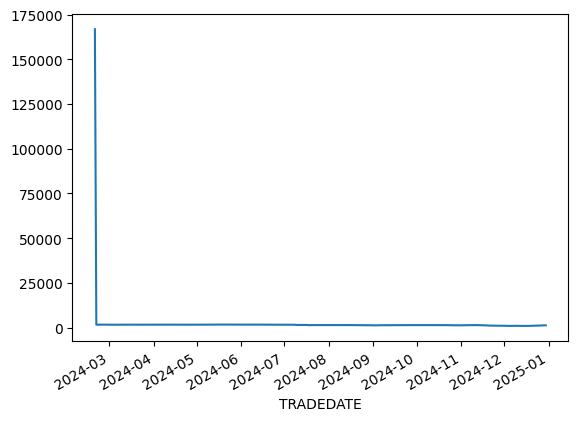

In [35]:
hist_prices[(hist_prices.index > '2024-02-19') & (hist_prices.index < '2025-01-01')].TRNFP.plot()

In [59]:
# def create_split_map() -> dict:
#     return {
#         "VTBR": "2024.07.15",   # (0,0002:1 Сплит акций)
#         "IRAO": "2015.01.20",	# 0,01:1 Сплит акций
#         "TRNFP": "2024.02.19",  # 100:1 Сплит акций
#     }

import pandas as pd
import numpy as np

def find_pre_event_dates(anomalies_series: pd.Series, prices_df: pd.DataFrame) -> dict:
    """
    Находит последнюю валидную дату перед датой аномалии (потенциального сплита).
    """
    split_candidates = {}
    # Получаем доступ к индексу дат из исходного DataFrame
    date_index = prices_df.index

    # Итерируемся по аномалиям (индекс серии - это кортежи (дата, тикер))
    for (anomaly_date, ticker), value in anomalies_series.items():
        try:
            # Находим целочисленную позицию аномальной даты в индексе
            loc = date_index.get_loc(anomaly_date)

            # Убеждаемся, что это не самый первый день в истории данных
            if loc > 0:
                # Получаем предыдущую дату по ее позиции (loc - 1)
                last_valid_date = date_index[loc - 1]
                
                split_candidates[ticker]= {
                    "start": last_valid_date.strftime('%Y-%m-%d'),
                    "end": anomaly_date.strftime('%Y-%m-%d'),
                    "change": f"{value:.2%}" # Форматируем для наглядности
                }
        except KeyError:
            # На случай, если дата из аномалий почему-то не найдена в исходном индексе
            print(f"Предупреждение: Дата {anomaly_date} для тикера {ticker} не найдена в индексе цен.")
            
    return split_candidates

split_info = find_pre_event_dates(anomalies_std.stack(), hist_prices)


In [60]:
split_info

{'MRKH': {'start': '2013-07-16', 'end': '2013-07-17', 'change': '8.02%'},
 'PHOR': {'start': '2013-08-14', 'end': '2013-08-15', 'change': '119.87%'},
 'OGKE': {'start': '2014-02-28', 'end': '2014-03-03', 'change': '-16.19%'},
 'AFKS': {'start': '2014-12-17', 'end': '2014-12-18', 'change': '106.20%'},
 'AGRO': {'start': '2014-12-18', 'end': '2014-12-19', 'change': '64.94%'},
 'IRAO': {'start': '2015-01-19', 'end': '2015-01-20', 'change': '10631.74%'},
 'SELG': {'start': '2016-02-19', 'end': '2016-02-20', 'change': '99.81%'},
 'VZRZ': {'start': '2016-05-12', 'end': '2016-05-13', 'change': '38.90%'},
 'AKRN': {'start': '2022-03-25', 'end': '2022-03-28', 'change': '40.22%'},
 'LNTA': {'start': '2022-03-29', 'end': '2022-03-30', 'change': '45.73%'},
 'POGR': {'start': '2022-07-11', 'end': '2022-07-12', 'change': '-76.98%'},
 'TRNFP': {'start': '2024-02-20', 'end': '2024-02-21', 'change': '-99.05%'},
 'GMKN': {'start': '2024-04-05', 'end': '2024-04-08', 'change': '-98.98%'},
 'VTBR': {'start

<Axes: xlabel='TRADEDATE'>

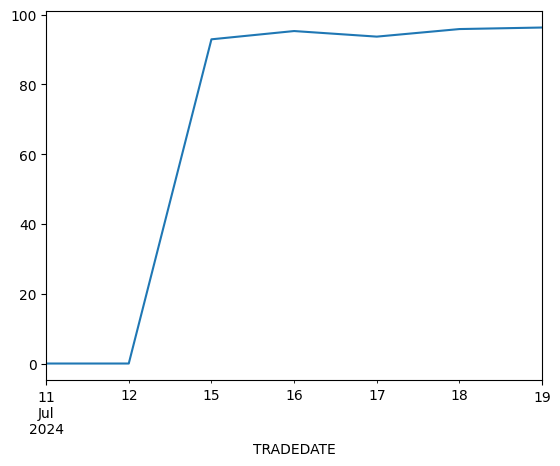

In [ ]:
hist_prices[(hist_prices.index > '2024-07-10') & (hist_prices.index < '2024-07-20')].VTBR.plot()

In [61]:
split_info["VTBR"]

{'start': '2024-07-12', 'end': '2024-07-15', 'change': '466282.34%'}

## 1. Data preporation

In [62]:
import datetime
def get_window(hist: pd.DataFrame, end_date: datetime.date, days: int) -> pd.DataFrame:
    start_date = end_date - datetime.timedelta(days=days - 1)
    return hist.loc[start_date:end_date]


# Пример использования
get_window(hist_prices, end_date=datetime.date(2024, 7, 9), days=7)

,AFKS,AFLT,AGRO,AKRN,ALRS,ASTR,AVAZ,AVAZP,BANE,BANEP,...,UGLD,UPRO,URKA,UWGN,VKCO,VSMO,VTBR,VZRZ,YDEX,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2024-07-03,23.521,60.91,1358.0,15620.0,70.42,576.70,NaN,NaN,3122.0,1984.5,...,0.8631,1.913,NaN,75.0,508.6,33180.0,0.020365,NaN,NaN,NaN
2024-07-04,22.825,59.04,1345.2,15598.0,69.87,561.80,NaN,NaN,3100.0,1949.5,...,0.8350,1.915,NaN,75.0,498.2,32700.0,0.020505,NaN,NaN,NaN
2024-07-05,22.979,58.45,1389.0,15610.0,70.04,554.80,NaN,NaN,3115.0,1931.5,...,0.8464,1.899,NaN,75.0,488.6,32940.0,0.020270,NaN,NaN,NaN
2024-07-08,22.713,56.45,1410.4,15548.0,68.89,542.85,NaN,NaN,3025.0,1921.0,...,0.8440,1.880,NaN,75.0,481.4,32540.0,0.019930,NaN,NaN,NaN
2024-07-09,22.545,53.78,1386.6,15498.0,68.05,519.45,NaN,NaN,2976.0,1823.0,...,0.8140,1.794,NaN,75.0,457.2,30600.0,0.019930,NaN,NaN,NaN


In [63]:
# Пример использования
test_asset_window = get_window(hist_prices, end_date=datetime.date(2025, 7, 9), days=100)
test_asset_window.dropna(axis=1, how='all', inplace=True)
test_asset_window



/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/3392504258.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_asset_window.dropna(axis=1, how='all', inplace=True)


,AFKS,AFLT,AKRN,ALRS,ASTR,BANE,BANEP,BSPB,CBOM,CHMF,...,TATNP,TRMK,TRNFP,UGLD,UPRO,UWGN,VKCO,VSMO,VTBR,YDEX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2025-04-01,15.947,66.02,16328.0,52.08,417.25,2219.5,1189.5,394.53,8.949,1137.0,...,615.0,120.96,1227.2,0.7152,1.766,46.82,274.5,34220.0,78.78,4355.5
2025-04-02,15.994,67.43,16154.0,52.58,429.65,2290.0,1198.0,399.80,8.919,1161.2,...,628.2,121.48,1280.2,0.7200,1.814,47.40,281.7,34400.0,79.88,4409.0
2025-04-03,16.300,70.36,16178.0,50.80,430.90,2233.5,1180.0,393.58,8.574,1122.2,...,618.4,119.10,1271.0,0.7105,1.853,46.78,279.1,34140.0,77.86,4291.0
2025-04-04,15.671,66.46,16116.0,48.81,406.85,2212.5,1139.5,382.25,8.053,1081.4,...,598.8,111.96,1208.4,0.6755,1.727,43.54,263.4,31240.0,72.25,4088.0
2025-04-07,14.685,64.07,16380.0,48.17,404.45,2050.0,1103.0,377.39,7.951,1053.4,...,611.8,105.32,1196.8,0.6666,1.671,42.06,257.1,29660.0,70.89,4069.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-03,15.351,65.09,15882.0,46.61,402.65,1875.5,1158.5,379.00,6.861,1063.0,...,612.5,106.14,1428.0,0.4774,1.522,39.74,293.0,28680.0,99.94,4121.5
2025-07-04,15.282,64.44,16032.0,46.25,398.45,1867.5,1150.5,378.70,6.929,1040.0,...,618.5,106.02,1418.6,0.4768,1.502,39.12,289.7,27780.0,99.38,4088.5
2025-07-07,15.269,63.12,16022.0,45.31,391.10,1826.5,1139.5,372.00,6.785,1011.8,...,613.3,104.78,1406.4,0.4768,1.499,38.54,284.2,27300.0,96.60,4060.0


## 2. Расчет весов

In [64]:
from pypfopt import HRPOpt, risk_models
from pypfopt import plotting

def calculate_hrp_weights(prices_df: pd.DataFrame, 
                          cov_method: str = 'ledoit_wolf',
                          max_weight: float = 1.0) -> pd.DataFrame:
    """
    Рассчитывает веса портфеля с использованием Hierarchical Risk Parity (HRP).

    Args:
        prices_df (pd.DataFrame): DataFrame с историческими ценами активов.
                                  Индекс - даты, колонки - тикеры.
        cov_method (str): Метод расчета ковариационной матрицы.
                          Поддерживаются все методы из pypfopt.risk_models, 
                          например, 'sample_cov', 'ledoit_wolf'.
        max_weight (float, optional): Максимальный допустимый вес для одного актива. 
                                      Если None, ограничения не применяются.

    Returns:
        pd.DataFrame: DataFrame с рассчитанными весами для каждого актива.
    """
    # returns = prices_df.pct_change().dropna()
    
    # 2. Рассчитываем робастную ковариационную матрицу
    if cov_method == 'ledoit_wolf': # Ledoit-Wolf Shrinkage
        cov_matrix = risk_models.risk_matrix(prices_df, method='ledoit_wolf')
    elif cov_method == 'sample_cov': # Используем стандартную выборочную ковариацию
        cov_matrix = risk_models.risk_matrix(prices_df, method='sample_cov')
    else:
        cov_matrix = None

    # 3. Создаем экземпляр HRPOpt
    hrp = HRPOpt(returns=None, cov_matrix=cov_matrix)
    
    # 4. Выполняем оптимизацию
    raw_weights = hrp.optimize()
    
    # Преобразуем веса в более удобный формат (DataFrame)
    weights_df = pd.DataFrame.from_dict(raw_weights, orient='index', columns=['weight'])
    weights_df.index.name = 'asset'
    
    # 5. Применяем бизнес-ограничения (пост-обработка)
    if max_weight < 1.0:
        # Находим активы, превышающие лимит
        overweight_assets = weights_df[weights_df['weight'] > max_weight]
        
        if not overweight_assets.empty:
            # "Срезаем" их вес до максимального
            weights_df.loc[overweight_assets.index, 'weight'] = max_weight
            
            # Рассчитываем "излишек" веса, который нужно перераспределить
            excess_weight = (overweight_assets['weight'] - max_weight).sum()
            
            # Определяем активы, которые не были срезаны
            underweight_assets_mask = weights_df['weight'] < max_weight
            
            # Пропорционально перераспределяем излишек между остальными
            original_underweight_sum = weights_df.loc[underweight_assets_mask, 'weight'].sum()
            
            if original_underweight_sum > 0:
                weights_df.loc[underweight_assets_mask, 'weight'] += \
                    weights_df.loc[underweight_assets_mask, 'weight'] / original_underweight_sum * excess_weight

    # Нормализуем веса, чтобы их сумма была в точности равна 1.
    weights_df['weight'] /= weights_df['weight'].sum()

    return weights_df

# --- Пример использования ---

In [65]:
test_asset_weights = calculate_hrp_weights(test_asset_window, cov_method='ledoit_wolf', max_weight=1.0)
test_asset_weights.head(15)

,weight
asset,
AFKS,0.001988
AFLT,0.003638
AKRN,0.131416
ALRS,0.007091
ASTR,0.022531
BANE,0.009624
BANEP,0.017500
BSPB,0.021972
CBOM,0.007411


In [66]:
# Test HRP

# Рассчитываем веса HRP без ограничений
print("\n--- Расчет HRP с Ledoit-Wolf (без ограничений) ---")
test_hrp_weights_unconstrained = calculate_hrp_weights(test_asset_window, cov_method='ledoit_wolf', max_weight=1.0)
print(test_hrp_weights_unconstrained.sort_values(by='weight', ascending=False).head(10))
print(f"Сумма весов: {test_hrp_weights_unconstrained['weight'].sum():.6f}")
print(f"Максимальный вес в портфеле: {test_hrp_weights_unconstrained['weight'].max():.4f}")

# Рассчитываем веса HRP с ограничением на максимальный вес
max_w = 0.05
print(f"\n--- Расчет HRP с Ledoit-Wolf (max_weight = {max_w:.0%}) ---")
test_hrp_weights_constrained = calculate_hrp_weights(test_asset_window, cov_method='ledoit_wolf', max_weight=max_w)
print(test_hrp_weights_constrained.sort_values(by='weight', ascending=False).head(10))
print(f"Сумма весов: {test_hrp_weights_constrained['weight'].sum():.6f}")
print(f"Максимальный вес в портфеле: {test_hrp_weights_constrained['weight'].max():.4f}")



--- Расчет HRP с Ledoit-Wolf (без ограничений) ---
         weight
asset          
AKRN   0.131416
MDMG   0.112356
SNGSP  0.043958
PHOR   0.029020
NKNC   0.025153
GCHE   0.024263
ASTR   0.022531
BSPB   0.021972
PLZL   0.021273
MSRS   0.018832
Сумма весов: 1.000000
Максимальный вес в портфеле: 0.1314

--- Расчет HRP с Ledoit-Wolf (max_weight = 5%) ---
         weight
asset          
SNGSP  0.052315
AKRN   0.050000
MDMG   0.050000
PHOR   0.034537
NKNC   0.029935
GCHE   0.028876
ASTR   0.026814
BSPB   0.026149
PLZL   0.025317
MSRS   0.022412
Сумма весов: 1.000000
Максимальный вес в портфеле: 0.0523


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/4187438381.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = test_asset_window.pct_change().dropna()


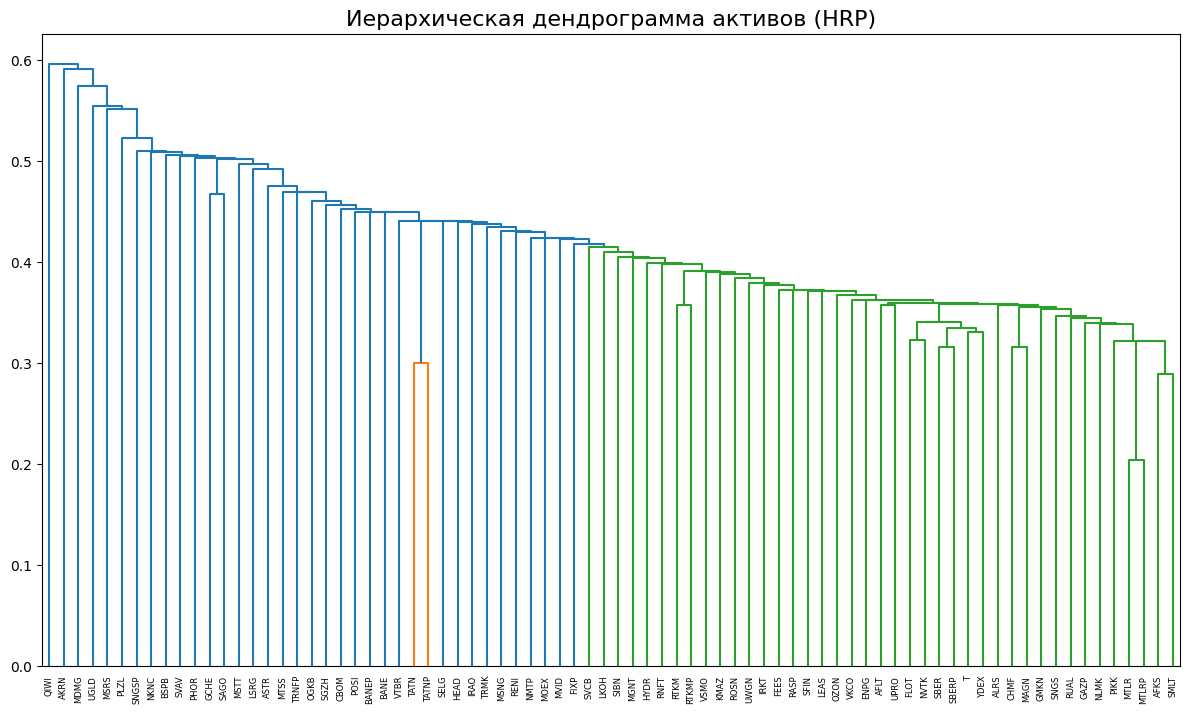

In [67]:
# Визуализация дендрограммы
import matplotlib.pyplot as plt
from pypfopt import HRPOpt, risk_models


returns = test_asset_window.pct_change().dropna()
cov_matrix = risk_models.risk_matrix(test_asset_window, method='ledoit_wolf')
hrp_vis = HRPOpt(returns=None, cov_matrix=cov_matrix)
hrp_vis.optimize()

fig, ax = plt.subplots(figsize=(12, 7))
plotting.plot_dendrogram(hrp_vis, ax=ax)
ax.set_title("Иерархическая дендрограмма активов (HRP)", fontsize=16)
plt.show()

## 3. Анализ рисков. ToDo

In [89]:
# ToDo 
def risk_analysis(weights_df: pd.DataFrame, prices_window: pd.DataFrame) -> pd.DataFrame:
    """
    В будущем здесь будет логика Monte-Carlo, VaR/CVaR и т.д.
    
    Args:
        weights_df (pd.DataFrame): Веса, предложенные HRP.
        prices_window (pd.DataFrame): Исторические данные, на которых считался HRP.
        
    Returns:
        pd.DataFrame: Скорректированные веса. Если сумма весов < 1,
                      остаток автоматически будет считаться кэшем.
    """
 
    return weights_df

## 4. Бектестинг с ребалансировкой

In [216]:
# Стратегия

import bt


class RebalanceHRP(bt.Algo):
    """
    Алгоритм для `bt`, который выполняет ребалансировку на основе HRP.
    """
    def __init__(self, window_days: int, max_asset_weight: float = 1.0):
        super(RebalanceHRP, self).__init__()
        self.window_days = window_days
        self.max_asset_weight = max_asset_weight

    def __call__(self, target):
        # target - это объект стратегии, который мы будем модифицировать
        current_date = target.now
        
        # 1. Получаем исторические данные для HRP
        prices_window = get_window(target.universe, current_date, self.window_days)
        prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
        
        # Проверяем, достаточно ли данных для расчета
        if len(prices_window) < self.window_days * 0.5:
            print(f"[{current_date.date()}] Пропуск ребалансировки: недостаточно данных ({len(prices_window)} дней).")
            return True # Ничего не делаем

        print(f"--- {current_date.date()}: Ребалансировка портфеля ---")
        
        # 2. Рассчитываем целевые веса HRP
        hrp_weights = calculate_hrp_weights(prices_window, max_weight=self.max_asset_weight)
        
        if hrp_weights.empty:
            print(f"[{current_date.date()}] Пропуск: HRP не смог рассчитать веса.")
            return True
        

        # 3. Проводим анализ риска (пока это заглушка)
        final_weights = risk_analysis(hrp_weights, prices_window)
        
        # 4. Устанавливаем новые целевые веса для портфеля
        target.temp['weights'] = final_weights['weight'].to_dict()
        
        print(f"[{current_date.date()}] Новые веса установлены. Сумма: {final_weights.sum().item():.2f}")
        return True
    

class LiquidateOnSplit(bt.Algo):
    """
    Алгоритм для `bt`, который ликвидирует позицию в день,
    являющийся последним торговым днем для актива,
    согласно заранее созданной карте делистингов.
    """
    def __init__(self, split_info_map: dict):
        super(LiquidateOnSplit, self).__init__()
        # Сохраняем нашу карту делистингов
        self.split_info_map = split_info_map
        
        self.working_date = set([i["start"] for i in self.split_info_map.values()])

    def __call__(self, target):
        current_date_str = target.now.strftime('%Y-%m-%d')
        if current_date_str not in self.working_date:
            return True
        
        # Проверяем каждый актив, который есть в портфеле
        for security_name in target.positions:
            ticker_split_info = self.split_info_map.get(security_name)
            if ticker_split_info:
                current_date_str = target.now.strftime('%Y-%m-%d')
                if current_date_str == ticker_split_info["start"]:
                    print(f"[{target.now.date()}] Дата split: "
                        f"Сегодня день перед SPLIT для {security_name}. "
                        f"Продаем позицию.")
                    
                    # Закрываем позицию по цене сегодняшнего дня
                    target.close(security_name)

                    
        return True
    


class LiquidateOnDelisting(bt.Algo):
    """
    Алгоритм для `bt`, который ликвидирует позицию в день,
    являющийся последним торговым днем перед сплитом/консалидацией,
    согласно заранее созданной карте сплитинга.
    """
    def __init__(self, delisting_map: pd.Series):
        super(LiquidateOnDelisting, self).__init__()
        # Сохраняем нашу карту делистингов
        self.delisting_map = delisting_map
        self.working_date = set(self.delisting_map.values)

    def __call__(self, target):
        if target.now not in self.working_date:
            return True
                
        # Проверяем каждый актив, который есть в портфеле
        for security_name in target.positions:
            # Проверяем, есть ли открытая позиция   
            position_quantity = target.positions[security_name]
            
            # if position_quantity != 0:
                # Получаем последнюю торговую дату для этого актива из нашей карты                
            last_day = self.delisting_map.get(security_name)

            # Если дата существует и СЕГОДНЯШНИЙ день - это тот самый последний день
            if last_day is not None and target.now == last_day:
                print(f"[{target.now.date()}] ПЛАНОВАЯ ЛИКВИДАЦИЯ: "
                    f"Сегодня последний торговый день для {security_name}. "
                    f"Продаем позицию.")
                
                # Закрываем позицию по цене сегодняшнего дня
                target.close(security_name)

                    
        return True



Данные для бэктеста подготовлены. Форма: (3126, 105)


  0%|          | 0/1 [00:00<?, ?it/s]

--- 2014-09-01: Ребалансировка портфеля ---
[2014-09-01] Новые веса установлены. Сумма: 1.00
[2014-11-28] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для OGKE. Продаем позицию.
--- 2014-12-01: Ребалансировка портфеля ---
[2014-12-01] Новые веса установлены. Сумма: 1.00
[2015-01-19] Дата split: Сегодня день перед SPLIT для IRAO. Продаем позицию.
--- 2015-06-01: Ребалансировка портфеля ---
[2015-06-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

--- 2015-09-01: Ребалансировка портфеля ---
[2015-09-01] Новые веса установлены. Сумма: 1.00
[2015-11-27] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для PGIL. Продаем позицию.
--- 2015-12-01: Ребалансировка портфеля ---
[2015-12-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2015-12-15] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для MMBM. Продаем позицию.
[2016-02-19] Дата split: Сегодня день перед SPLIT для SELG. Продаем позицию.
--- 2016-03-01: Ребалансировка портфеля ---
[2016-03-01] Новые веса установлены. Сумма: 1.00
[2016-05-12] Дата split: Сегодня день перед SPLIT для VZRZ. Продаем позицию.
--- 2016-06-01: Ребалансировка портфеля ---
[2016-06-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2016-06-30] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для EONR. Продаем позицию.
--- 2016-09-01: Ребалансировка портфеля ---
[2016-09-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2016-11-23] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для PHST. Продаем позицию.
--- 2016-12-01: Ребалансировка портфеля ---
[2016-12-01] Новые веса установлены. Сумма: 1.00
--- 2017-03-01: Ребалансировка портфеля ---
[2017-03-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

--- 2017-06-01: Ребалансировка портфеля ---
[2017-06-01] Новые веса установлены. Сумма: 1.00
[2017-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для RUALR. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


--- 2017-09-01: Ребалансировка портфеля ---
[2017-09-01] Новые веса установлены. Сумма: 1.00
--- 2017-12-01: Ребалансировка портфеля ---
[2017-12-01] Новые веса установлены. Сумма: 1.00
[2017-12-29] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для EPLN. Продаем позицию.
--- 2018-03-01: Ребалансировка портфеля ---
[2018-03-01] Новые веса установлены. Сумма: 1.00
--- 2018-06-01: Ребалансировка портфеля ---
[2018-06-01] Новые веса установлены. Сумма: 1.00
[2018-06-22] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для DIXY. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2018-11-26] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для AVAZ. Продаем позицию.
[2018-11-26] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для AVAZP. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


--- 2019-03-01: Ребалансировка портфеля ---
[2019-03-01] Новые веса установлены. Сумма: 1.00
[2019-04-24] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для VZRZ. Продаем позицию.
[2019-05-29] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для MFON. Продаем позицию.
[2019-09-17] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для URKA. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

--- 2020-06-01: Ребалансировка портфеля ---
[2020-06-01] Новые веса установлены. Сумма: 1.00
--- 2020-09-01: Ребалансировка портфеля ---
[2020-09-01] Новые веса установлены. Сумма: 1.00
--- 2020-12-01: Ребалансировка портфеля ---
[2020-12-01] Новые веса установлены. Сумма: 1.00
--- 2021-03-01: Ребалансировка портфеля ---
[2021-03-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

--- 2021-06-01: Ребалансировка портфеля ---
[2021-06-01] Новые веса установлены. Сумма: 1.00
--- 2021-09-01: Ребалансировка портфеля ---
[2021-09-01] Новые веса установлены. Сумма: 1.00
--- 2021-12-01: Ребалансировка портфеля ---
[2021-12-01] Новые веса установлены. Сумма: 1.00
[2021-12-13] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для MAIL. Продаем позицию.
[2022-02-21] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для IRGZ. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


--- 2022-03-01: Ребалансировка портфеля ---
[2022-03-01] Новые веса установлены. Сумма: 1.00
[2022-03-25] Дата split: Сегодня день перед SPLIT для AKRN. Продаем позицию.
[2022-03-29] Дата split: Сегодня день перед SPLIT для LNTA. Продаем позицию.
[2022-04-13] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для LNTA. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


--- 2022-06-01: Ребалансировка портфеля ---
[2022-06-01] Новые веса установлены. Сумма: 1.00
[2022-07-11] Дата split: Сегодня день перед SPLIT для POGR. Продаем позицию.
[2022-07-12] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для POGR. Продаем позицию.
--- 2022-09-01: Ребалансировка портфеля ---
[2022-09-01] Новые веса установлены. Сумма: 1.00
--- 2022-12-01: Ребалансировка портфеля ---
[2022-12-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2022-12-20] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для RSTI. Продаем позицию.


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

--- 2023-03-01: Ребалансировка портфеля ---
[2023-03-01] Новые веса установлены. Сумма: 1.00
--- 2023-06-01: Ребалансировка портфеля ---
[2023-06-01] Новые веса установлены. Сумма: 1.00
--- 2023-09-01: Ребалансировка портфеля ---
[2023-09-01] Новые веса установлены. Сумма: 1.00
--- 2023-12-01: Ребалансировка портфеля ---
[2023-12-01] Новые веса установлены. Сумма: 1.00
[2024-02-20] Дата split: Сегодня день перед SPLIT для TRNFP. Продаем позицию.
--- 2024-03-01: Ребалансировка портфеля ---
[2024-03-01] Новые веса установлены. Сумма: 1.00


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_54499/1486387891.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_window.dropna(axis=1, how='any', inplace=True) # Удаляем колонку с активом который NaN


[2024-03-27] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для DSKY. Продаем позицию.
[2024-04-03] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для FIVE. Продаем позицию.
[2024-04-05] Дата split: Сегодня день перед SPLIT для GMKN. Продаем позицию.
[2024-06-14] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для YNDX. Продаем позицию.
[2024-07-12] Дата split: Сегодня день перед SPLIT для VTBR. Продаем позицию.
[2024-08-09] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для HHRU. Продаем позицию.
[2024-09-23] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для POLY. Продаем позицию.
[2024-10-18] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для GLTR. Продаем позицию.
[2024-11-27] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для TCSG. Продаем позицию.
[2024-12-02] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для AGRO. Продаем позицию.
[2025-03-26] Дата split: Сегодня день перед SPLIT для PLZL. Продаем позицию.
[2025-06-20] ПЛАНОВАЯ ЛИК

100%|██████████| 1/1 [00:18<00:00, 18.38s/it]

[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для RUAL. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для UWGN. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для CBOM. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для UPRO. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для RNFT. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для SFIN. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для ENPG. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для FLOT. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для MDMG. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для OZON. Продаем позицию.
[2025-08-08] ПЛАНОВАЯ ЛИКВИДАЦИЯ: Сегодня последний торговый день для 

                           price   quantity
Date       Security                        
2014-09-01 AFLT        47.100000      286.0
           ALRS        40.050000      987.0
           DIXY       419.640000       28.0
           GCHE       648.100000       47.0
           HYDR         0.687000    49382.0
           IRAO         0.009006  1215474.0
           LKOH      2034.900000       30.0
           LSRG       575.000000       24.0
           MGNT      8900.000000        2.0
           MOEX        60.550000      288.0


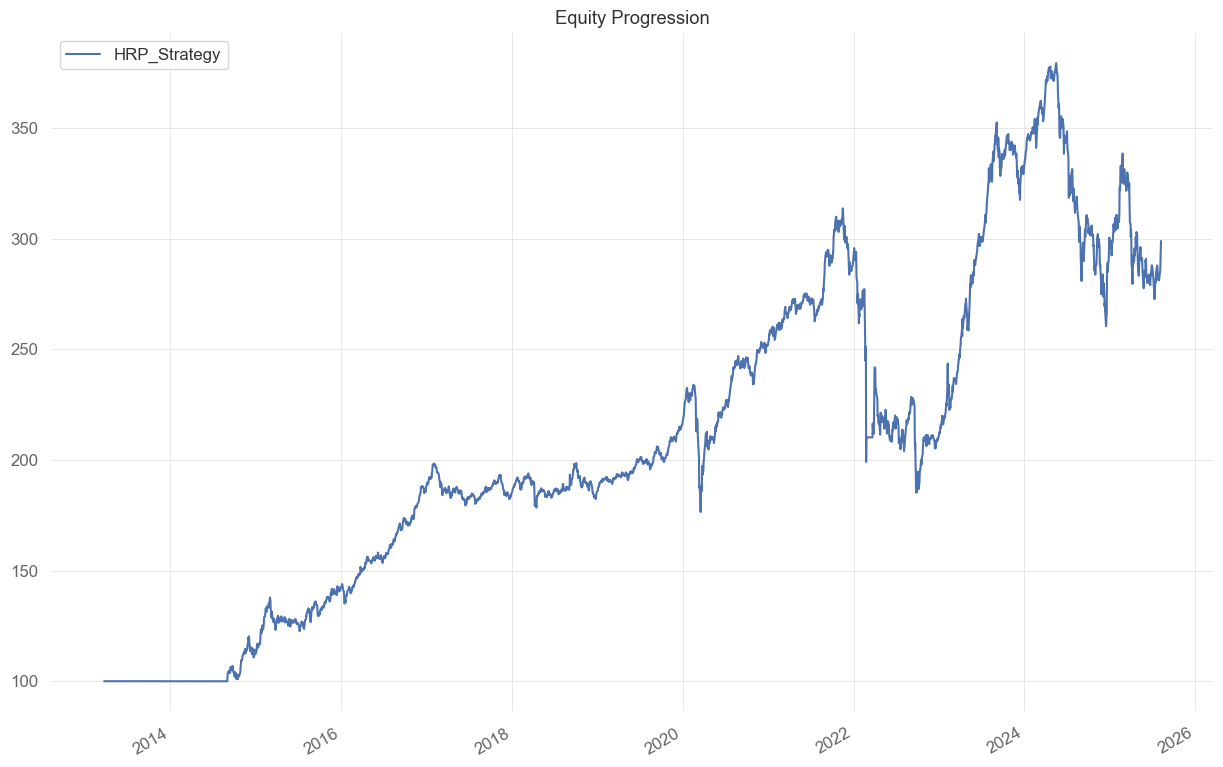

In [268]:
# --- Параметры бэктеста ---
initial_capital = 1_000_000
rebalance_period_months = 3 # Ребалансировка раз в N месяца
hrp_window_days = 250       # Данные за последний год для HRP
max_asset_weight = 0.10     # Максимальный вес на один актив

# Ставка комиссии 0.03% в виде десятичной дроби
commission_rate = 0.03 / 100

print("Данные для бэктеста подготовлены. Форма:", hist_prices.shape)

# --- Создание стратегии ---

# Определяем даты ребалансировки (например, начало каждого квартала)
rebalance_dates = hist_prices.resample(f'{rebalance_period_months}MS').first().index


# --- СОЗДАЕМ КАРТУ ДЕЛИСТИНГОВ ---
delisting_map = create_delisting_map(hist_prices)


# Собираем стратегию из "алго-блоков"
hrp_strategy = bt.Strategy('HRP_Strategy', [
    LiquidateOnDelisting(delisting_map=delisting_map),
    LiquidateOnSplit(split_info_map=split_info),
    bt.algos.RunOnDate(*rebalance_dates), # Запускаться только в наши даты
    bt.algos.SelectAll(),                # Рассматривать все активы
    bt.algos.WeighEqually(),             # Начальное взвешивание (только на старте)
    RebalanceHRP(                        # Наш кастомный алгоритм HRP
        window_days=hrp_window_days, 
        max_asset_weight=max_asset_weight
    ),
    bt.algos.Rebalance()                 # Алгоритм, который приводит портфель к целевым весам
])


trade_commissions = lambda q, p: abs(q) * p * commission_rate


# --- Запуск бэктеста ---
backtest = bt.Backtest(hrp_strategy, hist_prices, initial_capital=initial_capital, commissions=trade_commissions)



# Запускаем их вместе!
results = bt.run(backtest)


 # --- Отображение результатов ---
print("\n\n--- Результаты Бэктеста ---")
results.display()

print("\n--- Графики ---")
results.plot(figsize=(15, 10))

# Можно также получить доступ к отдельным транзакциям
print("\n--- Пример транзакций ---")
print(results.get_transactions().head(10))


--- Стандартный дашборд ---


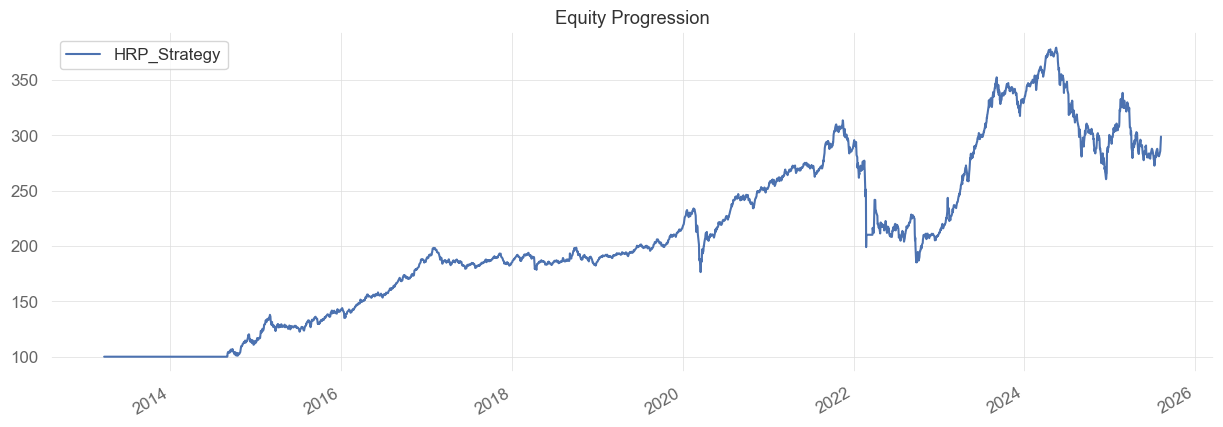

In [269]:
import matplotlib.pyplot as plt

# Увеличим стандартный размер графиков для лучшей читаемости
plt.rcParams['figure.figsize'] = (15, 10)

print("\n--- Стандартный дашборд ---")
results.plot()
plt.show()

In [270]:
import bt
import quantstats as qs

# --- 1. Запуск бэктеста ---
# Сохраняем ПОЛНЫЕ результаты в переменную и не трогаем ее.
# Назовем ее, например, full_results, чтобы избежать путаницы.
full_results = bt.run(backtest)

# --- 2. Извлечение первого (и единственного) результата ---
# Теперь будем работать только с этой переменной
strategy_result = full_results[0]

# --- 3. Отображение статистики ---
# Мы берем статистику из нашего объекта, но НЕ перезаписываем его
print("--- Результаты Бэктеста ---")
strategy_result.display() # или print(strategy_result.stats)


100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]

--- Результаты Бэктеста ---
Stats for HRP_Strategy from 2013-03-24 00:00:00 - 2025-08-08 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
198.91%             0.67  9.25%   -40.91%

Annualized Returns:
mtd    3m     6m      ytd     1y      3y      5y     10y    incep.
-----  -----  ------  ------  ------  ------  -----  -----  --------
5.95%  3.04%  -2.70%  -0.51%  -4.75%  13.03%  4.32%  8.55%  9.25%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.67     0.64       0.53
mean    9.95%    10.16%     11.49%
vol     14.75%   15.97%     21.63%
skew    -4.05    -1.04      0.36
kurt    87.65    5.32       1.01
best    6.68%    13.32%     56.89%
worst   -20.70%  -22.89%    -27.43%

Drawdowns:
max      avg       # days
-------  ------  --------
-40.91%  -2.23%      31.9

Misc:
---------------  ------
avg. up month    3.56%
avg. down month  -2.66%
u

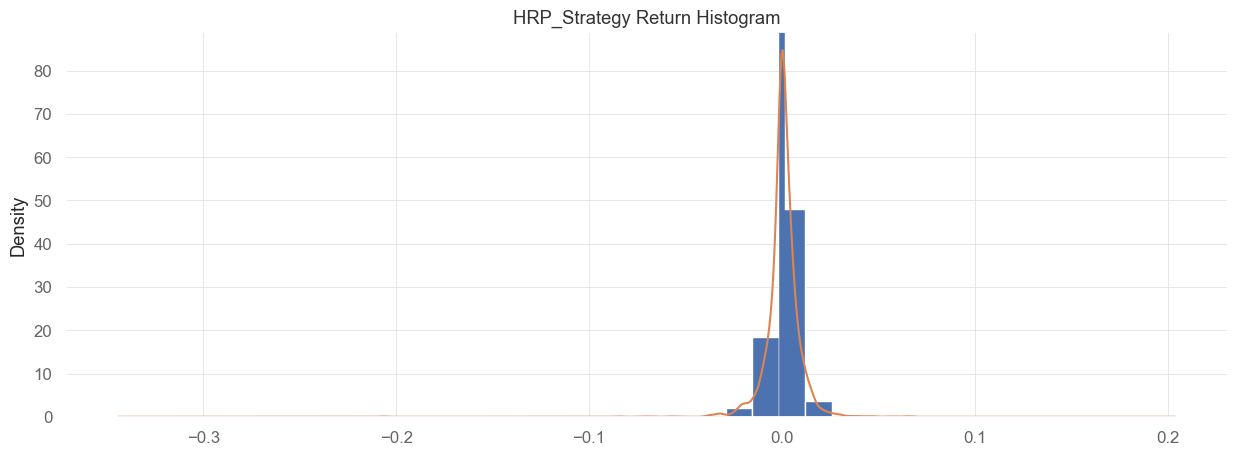

In [271]:
results.plot_histogram()

In [272]:
results.display_monthly_returns()

  Year    Jan     Feb    Mar    Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  ------  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2013   0       0      0      0      0      0      0      0       0      0      0      0       0
  2014   0       0      0      0      0      0      0      0       4.18   5.14   6.27  -3.7    12.09
  2015  11.73    7.71  -6.4    0.88  -2.09   1.27   0.97   4.73   -1.9    4.39   1.98   2.22   27.19
  2016  -1.2     2.7    3.82   3.02   0.56  -0.31   4.14   3.99    2.86   0.75   4.95   2.72   31.62
  2017   5.57   -5.24  -1.14   0.34  -0.9   -1.16  -1.08   2.76    0.92   1.59  -2.49  -0.42   -1.65
  2018   2.99    0.76  -0.55  -2.46  -1.05   1.13   0.11   0.35    5.76  -4.17   0.16  -2.3     0.37
  2019   3.06   -0.24   1.13   0.09   0.61   2.95   0.2    0.61    0.91   0.33   2.98   2.82   16.5
  2020   5.79   -6.76  -6.11   5.09   3.22   3.04   6.02   2.75    0.83  -4.56   6.99   0.48   

In [273]:
results.display_lookback_returns()

,HRP_Strategy
mtd,5.95%
3m,3.04%
6m,-2.70%
ytd,-0.51%
1y,-4.75%
3y,13.03%
5y,4.32%
10y,8.55%
incep,9.25%


In [274]:
prices = results[0]

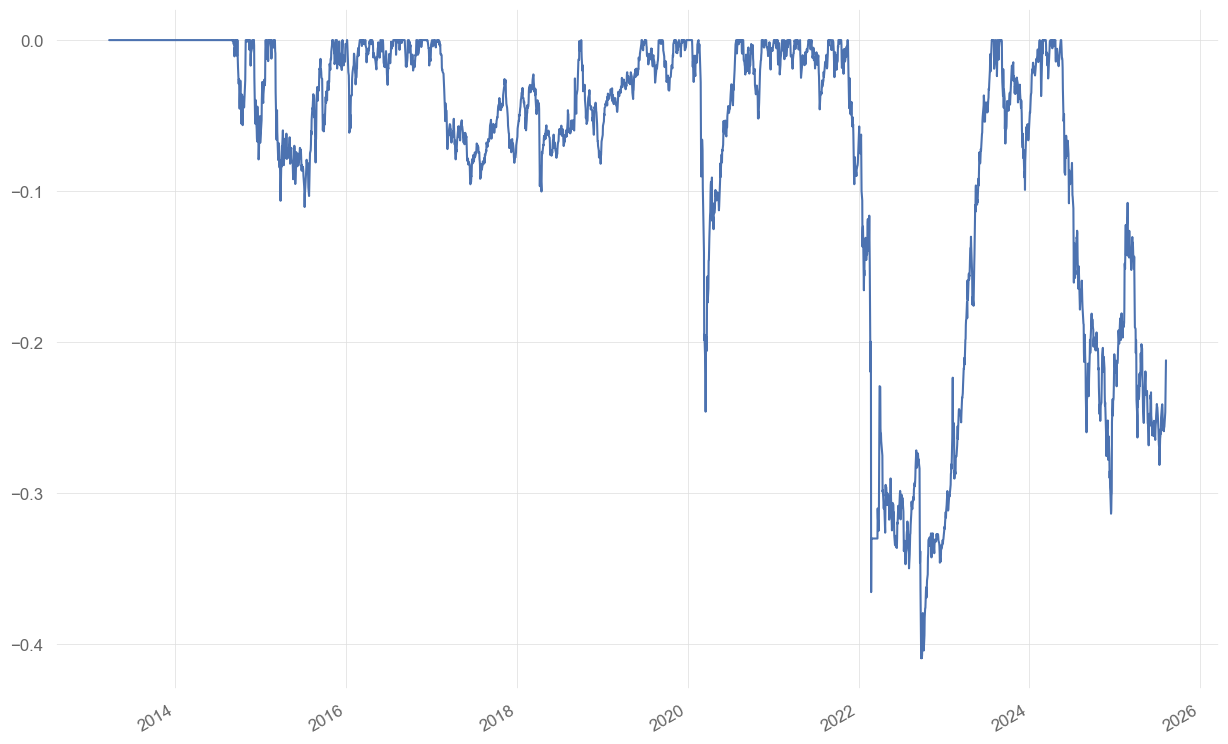

In [275]:
ax = prices.prices.to_drawdown_series().plot(figsize=(15, 10))


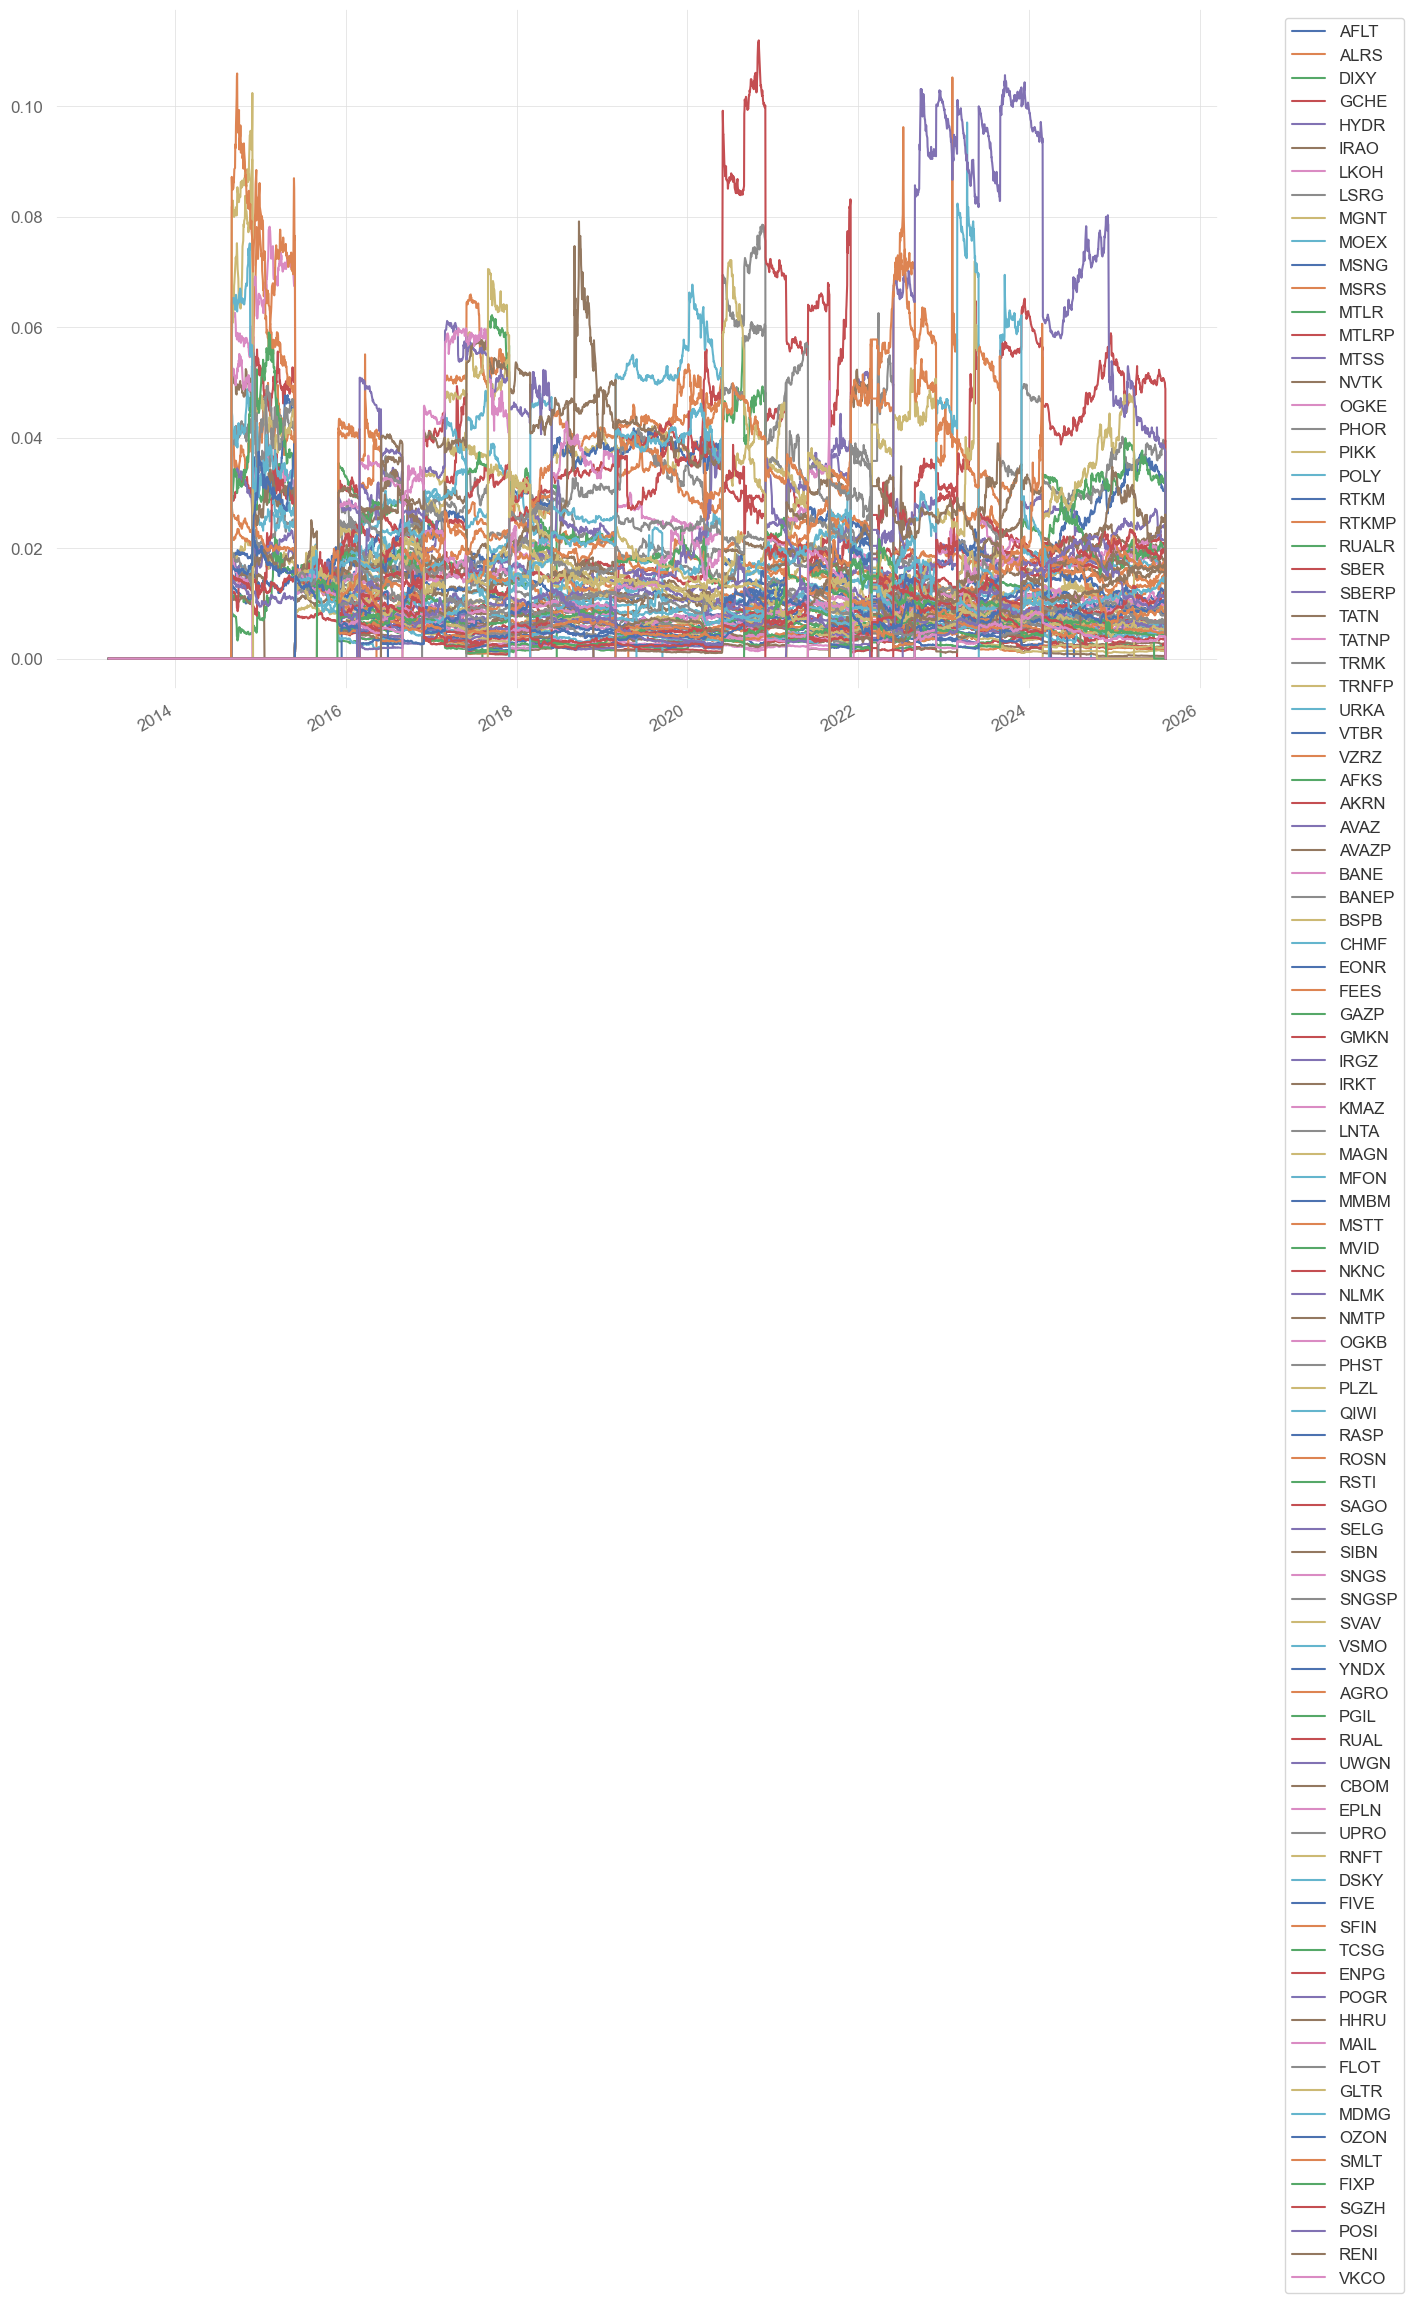

In [276]:
ax = results.get_security_weights().plot()
L=plt.legend()
L = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [277]:

transactions = results.get_transactions()

print(f"Всего совершено транзакций: {len(transactions)}")
print("Первые 10 транзакций:")
print(transactions.head(10))

# Рассчитываем общий торговый оборот
total_turnover = (abs(transactions['quantity']) * transactions['price']).sum()
print(f"\nОбщий торговый оборот за весь период: {total_turnover:,.2f} руб.")

# Рассчитываем общую сумму уплаченных комиссий
commission_rate = 0.003
total_commissions_paid = total_turnover * commission_rate
print(f"Общая сумма комиссий за весь период: {total_commissions_paid:,.2f} руб.")


Всего совершено транзакций: 2276
Первые 10 транзакций:
                           price   quantity
Date       Security                        
2014-09-01 AFLT        47.100000      286.0
           ALRS        40.050000      987.0
           DIXY       419.640000       28.0
           GCHE       648.100000       47.0
           HYDR         0.687000    49382.0
           IRAO         0.009006  1215474.0
           LKOH      2034.900000       30.0
           LSRG       575.000000       24.0
           MGNT      8900.000000        2.0
           MOEX        60.550000      288.0

Общий торговый оборот за весь период: 32,233,328.45 руб.
Общая сумма комиссий за весь период: 96,699.99 руб.


## ToDo